In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
import torch
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sim_name = 'TNG100-1'
#sim_name = 'TNG50-4'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = ''
geo_tag = ''
scalar_tag = ''
mass_multiplier = 1e10
log_mass_shift = 10

## Load features

In [3]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'
print(fn_halo_config)
fn_geo_config = f'../configs/geo_{sim_name}{halo_tag}{geo_tag}.yaml'
print(fn_geo_config)
fn_scalar_config = f'../configs/scalar_{sim_name}{halo_tag}{geo_tag}{scalar_tag}.yaml'
print(fn_scalar_config)

../configs/halos_TNG100-1.yaml
../configs/geo_TNG100-1.yaml
../configs/scalar_TNG100-1.yaml


In [4]:
with open(fn_scalar_config, 'r') as file:
    scalar_params = yaml.safe_load(file)
scp = scalar_params['scalar']

fn_geo_config = scalar_params['geo']['fn_geo_config']
with open(fn_geo_config, 'r') as file:
    geo_params = yaml.safe_load(file)
gp = geo_params['geo']

with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

fn_dark_halo_arr = halo_params['halo']['fn_dark_halo_arr']

In [5]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(gp['fn_geo_features'])

In [6]:
sim_reader = SimulationReader(halo_params['sim']['base_dir'], sim_name, sim_name_dark, 
                              halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()

In [7]:
mrv_for_rescaling = utils.get_mrv_for_rescaling(sim_reader, scp['mrv_names_for_rescaling'])
scalar_featurizer = ScalarFeaturizer(geo_featurizer.geo_feature_arr,
                        n_groups_rebin=scp['n_groups_rebin'], 
                        transform_pseudotensors=scp['transform_pseudotensors'], 
                        mrv_for_rescaling=mrv_for_rescaling)

Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features


In [8]:
x_features_extra = np.log10(mrv_for_rescaling).T

In [9]:
print('loading')
scalar_featurizer.load_features(scp['fn_scalar_features'])
print('loaded')

loading
loaded


## Other features

In [10]:
x_dict = {}
x_extra_dict = {}

In [11]:
x_dict['scalars'] = scalar_featurizer.scalar_features
x_extra_dict['scalars'] = x_features_extra

x_dict['geos'] = utils.geo_feature_arr_to_values(scalar_featurizer.geo_feature_arr)
x_extra_dict['geos'] = x_features_extra

x_dict['mrv'] = x_features_extra
x_extra_dict['mrv'] = None

catalog_feature_names = ['M200c', 'c200c', 'a_form']
sim_reader.get_structure_catalog_features(catalog_feature_names)
x_dict['catalog'] = sim_reader.x_catalog_features
x_extra_dict['catalog'] = None

## Gather properties

In [12]:
sim_reader.add_catalog_property_to_halos('m200m')
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_200m = np.log10(m_200m)

## Split train-val-test

In [13]:
frac_train = 0.70
frac_val = 0.15
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, 
                                                      frac_val=frac_val, frac_test=frac_test)

In [14]:
x_test = scalar_featurizer.scalar_features[idx_test]
y_test_current = None
x_test_extra = x_features_extra[idx_test]

## Mstellar

In [50]:
y_label_name = 'm_stellar'

In [64]:
fit_tag = f'_{y_label_name}_nn_scalars_epochs500_lr5e-05_hs128_f0.01'

fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [65]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [66]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

In [67]:
import torch
model_checkpoint = torch.load(fn_model)

266 10.528742119867816


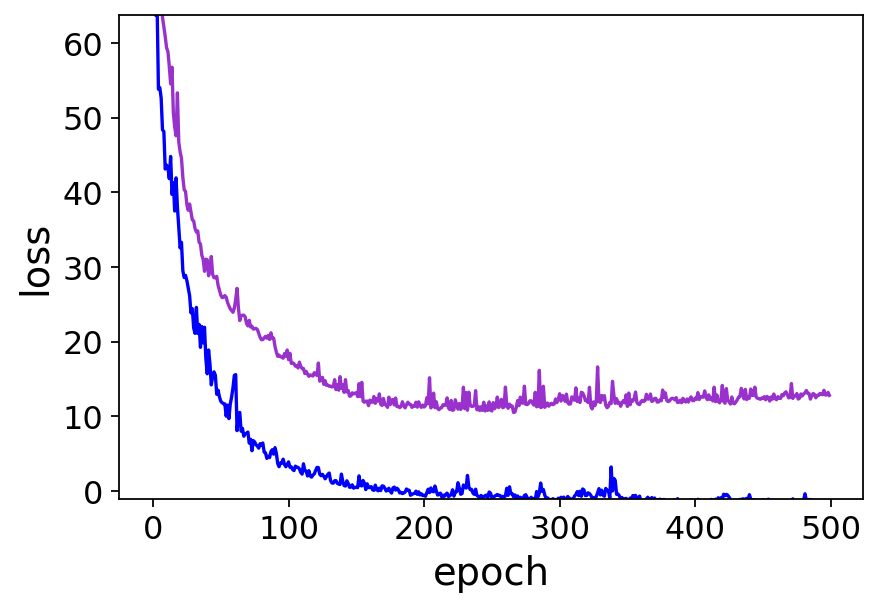

In [68]:
plt.plot(nnfitter.loss_valid, color='darkorchid', label='Validation')
plt.plot(nnfitter.loss_train, color='blue', label='Training')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0,300)
plt.ylim(-1, nnfitter.loss_train[2])
print(np.argmin(nnfitter.loss_valid), np.min(nnfitter.loss_valid))

In [69]:
# plt.plot(nnfitter.loss, color='darkorchid')
# plt.xlabel('epoch')
# plt.ylabel('loss')

In [70]:
y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:327: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


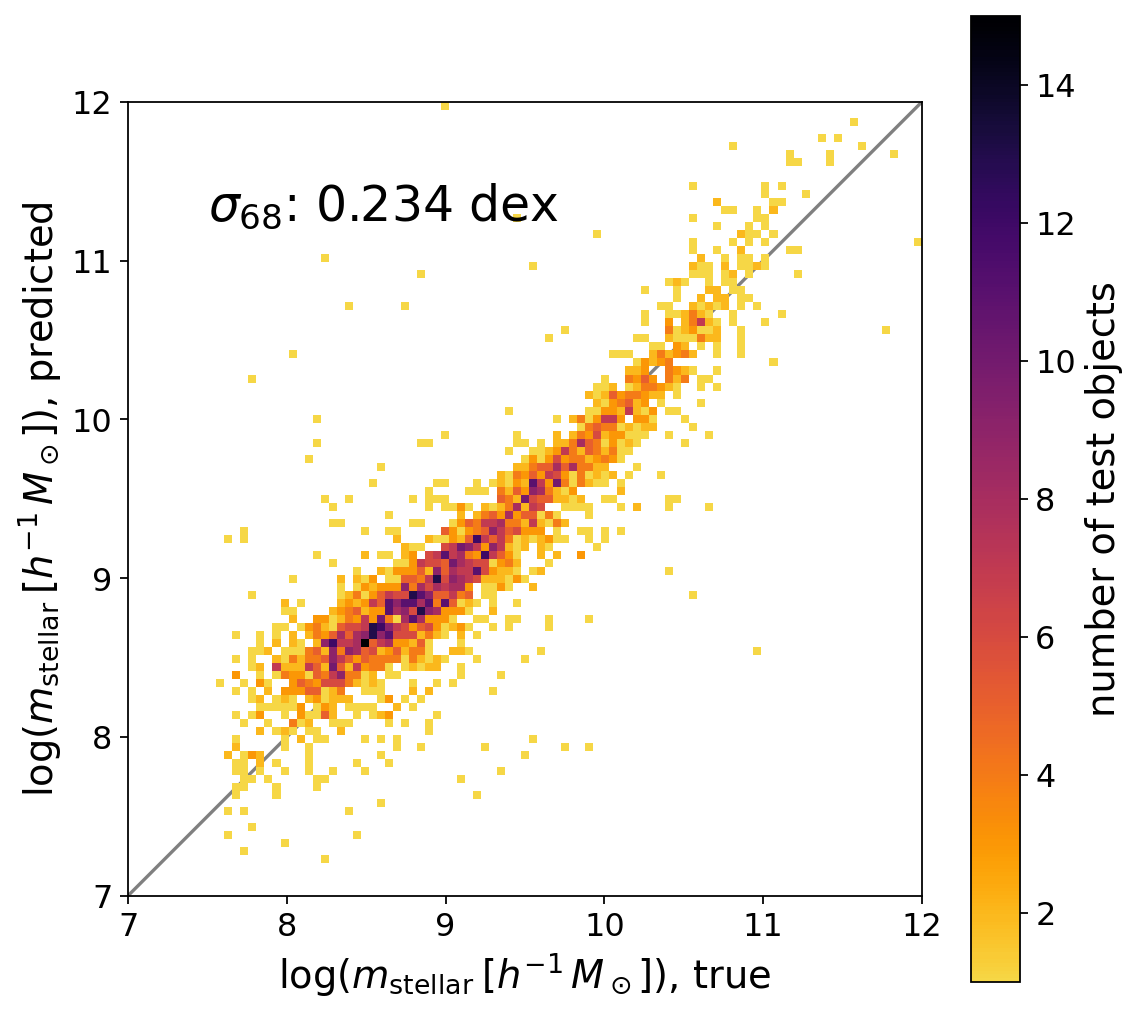

In [71]:
y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
plotter.plot_pred_vs_true_hist(y_label_name, y_test_mult, y_pred_mult, text_results=error_str,
                               x_lim=(7,12),  y_lim=(7,12))

In [27]:
def plot_error_fig(y_true, y_pred):
    plt.figure()
    bins = np.linspace(np.min(y_true), np.max(y_true), 14)
    delta_y = y_pred - y_true
    delta_y_binned = np.empty(len(bins)-1)
    for i in range(len(bins)-1):
        idx_inbin = (y_true >= bins[i]) & (y_true < bins[i+1])
        delta_y_binned[i] = np.median(delta_y[idx_inbin])
    bins_avg = 0.5*(bins[1:] + bins[:-1])
    plt.plot(bins_avg, delta_y_binned)

# loop to get all

In [28]:
y_label_name = 'm_stellar'

In [29]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [33]:
sfeat = scalar_featurizer.scalar_features

In [72]:
feature_names = ['geos', 'scalars']
fracs_subset = [0.005, 0.01, 0.05, 0.1, 0.5, 1]
errors = []
for ff, feature_name in enumerate(feature_names):
    errors_feature = []
    x = x_dict[feature_name]
    x_extra = x_extra_dict[feature_name]
    if x is not None:
        x_test = x[idx_test]
    else:
        x_test = None
    if x_extra is not None:
        x_test_extra = x_extra[idx_test]
    else:
        x_test_extra = None
        
    for i, frac_subset in enumerate(fracs_subset):
        # this is just cuz i kept doing diff ones, eventually standardize max_epochs and f tag
        if frac_subset == 1.0:
            frac_tag = ''
            max_epochs = 1000
        elif frac_subset<=0.05:
            frac_tag = f'_f{frac_subset}'
            max_epochs = 500            
        else:
            frac_tag = f'_f{frac_subset}'
            max_epochs = 2000
            
        fit_tag = f'_{y_label_name}_nn_{feature_name}_epochs{max_epochs}_lr5e-05_hs128{frac_tag}'
        fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'
        nnfitter = NNFitter()
        nnfitter.load_model(fn_model)
        y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)
        y_test_mult = y_test + log_mass_shift
        y_pred_mult = y_pred + log_mass_shift
        error, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
        errors_feature.append(error)
    
    errors.append(errors_feature)

In [77]:
ns_train = np.array(fracs_subset) * len(idx_train)

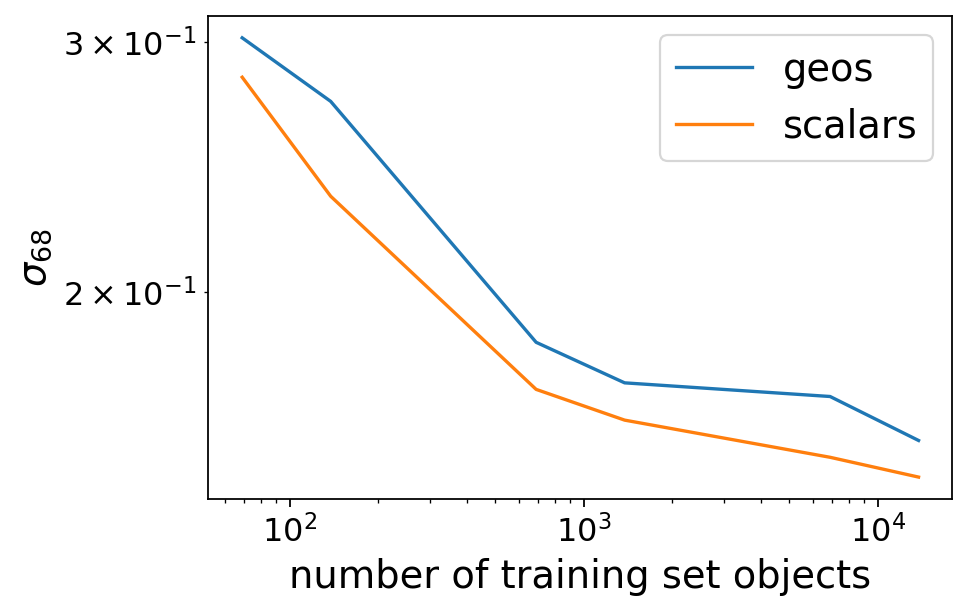

In [79]:
for ff, feature_name in enumerate(feature_names):
    plt.plot(ns_train, errors[ff], label=feature_name)

plt.legend()
plt.xlabel('number of training set objects')
plt.ylabel(r'$\sigma_{68}$')
plt.xscale('log')
#plt.yscale('log')